In [11]:
import numpy as np
import numpy,scipy,corner
import nestle
import astropy,warnings
from scipy.interpolate import interp1d as interp
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as multi_gauss

#---------------------------------------------------------------------

import Library_GraphTwoDimensionDensityColorMap
#---------------------------------------------------------------------
warnings.simplefilter('ignore')
print ("done importing")

done importing


In [19]:
#Read the generated data from a file, and store as a python variable:
my_data_1D = astropy.io.ascii.read( "1D_Generated_Data.astropydat" )
#print( my_data_1D )

#Read the generated data from a file, and store as a python variable:
my_data_2D = astropy.io.ascii.read( "2D_Generated_Data.astropydat" )
#print( my_data_2D )



In [31]:
#The experimentalist gives us data, and the error in his/her observation of that data. 
#    Experimenalist should know and report the errors of their instrument
#    In our case we are given the uncertainty in height measurment, or height&time measurment


datapoint_count = len(my_data_1D['time'])

#   (we have uncertainty in the same units as the height --> meters)
measurement_uncertainty = 10
errors=[measurement_uncertainty]*datapoint_count


#Define the measurment error function which is something the experimentalist would give us.
covariance_matrix = np.array(
    [
        [.58,   13.35],
        [13.35, 501.77]
    ])
covariance_matrix_list = [covariance_matrix]*datapoint_count

In [32]:
#SECRET
#Set the variables for our model, and the model itself
v = 50
g = 9.8
def my_model( v, g, t):
    return v*t -.5*g*t**2



In [33]:
#(SECRET)
#Pick some times of which to observe the height
times=np.linspace(.1,10,20) # measurement times


#figure out the heights which are "real" for the given times above
perfect_data=my_model(v,g,times)


In [34]:
#(SECRET)
#Generate 1D uncertainty dataset
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   



#Introduce error into the "perfect" data using the experiment error
heights=np.random.normal(perfect_data,errors)
my_data_1D=Table([times,heights,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_1D, "1D_Generated_Data.astropydat" , overwrite = True )


In [35]:
#(SECRET)
#Generate 1D uncertainty dataset with a model that will not work with
#   a simple chi-square minimization.
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   .

#Set the variables for our model, and the model itself
bad_v = 50
bad_g = -10
def my_bad_model( v,g, t):
    return v*t -.5*g**2*t**2

#Generate "perfect" data with the bad model.
perfect_bad_data=my_bad_model(bad_v,bad_g,times)
#Introduce error into the "perfect" data using the experiment error
heights_bad=np.random.normal(perfect_bad_data,errors)
my_bad_data_1D=Table([times,heights_bad,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_bad_data_1D, "1D_Generated_Data_ChiProblem.astropydat" , overwrite = True )

In [36]:
#(SECRET)
#Generate 2D uncertainty dataset
#   By 2D, we mean that we have only error in BOTH
#      the height measurement  
#      AND time measurement error 
#   The errors are not mutually exclusive. 
#   The errors can be thought of as DEPENDENT RANDOM VARIABLES


covariance_matrices=[covariance_matrix]*len(perfect_data)

#Use the measurment error function to take the perfect data, and mess it up
times_2d=[]
heights_2d=[]
for i in range(len(perfect_data)):
    t,f=np.random.multivariate_normal(
                    mean=[times[i],perfect_data[i]],
                    cov=covariance_matrix)
    times_2d.append(t)
    heights_2d.append(f)

my_data_2D=Table([times_2d,heights_2d],names=('time','height'))

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_2D, "2D_Generated_Data.astropydat", overwrite = True )





In [37]:
def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return multi_gauss.pdf(x, mu, cov)
    return experiment_error_function

**Data Plotting**
==============

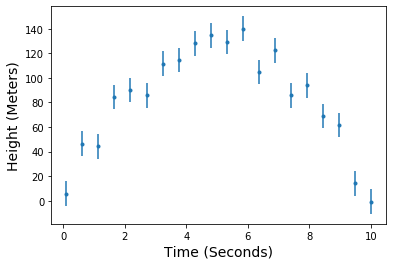

In [38]:
#Plot the 1D data
plt.errorbar( my_data_1D['time'], my_data_1D['height'], yerr =  my_data_1D['error'], fmt = ".")
plt.ylabel('Height (Meters)',fontsize=14)
plt.xlabel('Time (Seconds)',fontsize=14)
plt.show()


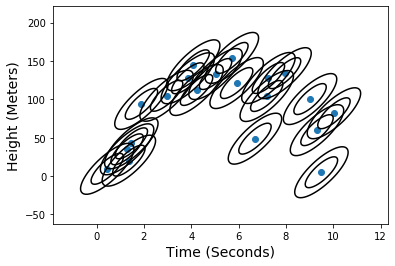

In [39]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.xlabel('Time (Seconds)',fontsize=14)
plt.ylabel('Height (Meters)',fontsize=14)
plt.show()

**Data Fitting: Chi-Square Minimization**
===============================

In [43]:
#Let's try and fit the data with a simple chi-square minimization
    
def chisquare(parameters,args):
    #This function accepts a set of model parameters v and g
        #and returns a chi square value, comparing with the 
        #times,observations,errors, and model provided in args
    v,g=parameters
    observed_times,observed_values,observed_errors,model_func=args
    model_values=model_func(v,g,observed_times)
    z = (observed_values - model_values) / observed_errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

my_args=[my_data_1D['time'],my_data_1D['height'],my_data_1D['error'],my_model]
result =  scipy.optimize.minimize(
    chisquare,[50,50],
    args=my_args,
    bounds=[(0,100),(0,100)] 
    )
print(result.x)

[51.87006844 10.37073644]


In [ ]:
#Now let's look at a drawback of the chi-square minimization.
#    What if there are parameter degeneracies in the model,
#    or some sort of local minimum in the chi-square?
    
v_tries = []
g_tries = []
chi_tries=[]
def callback(x):
    v_tries.append(x[0])
    g_tries.append(x[1])
    chi_tries.append(chisquare(x,my_args))
    
def chisquare(parameters,args):
    #This function accepts a set of model parameters v and g
        #and returns a chi square value, comparing with the 
        #times,observations,errors, and model provided in args
    v,g=parameters
    observed_times,observed_values,observed_errors,model_func=args
    model_values=model_func(v,g,observed_times)
    z = (observed_values - model_values) / observed_errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

#This model has one of the parameters squared, so either -g or g will give
#    the same result
def my_bad_model(v,g,t):
    return(v*t-.5*g**2*t**2)

#Read in some data generated with this model. The parameters used were v=50,g=-10
my_bad_data_1D=astropy.io.ascii.read("1D_Generated_Data_ChiProblem.astropydat")

#Try and fit the data with this model, using new bounds
my_args=[my_bad_data_1D['time'],my_bad_data_1D['height'],my_bad_data_1D['error'],my_bad_model]
result =  scipy.optimize.minimize(chisquare,[50,5],args=my_args,
                                                  bounds=[(-100,100),(-20,20)],
                                                  callback=callback)
print(result.x)
plt.plot(v_tries,chi_tries)
plt.show()
plt.plot(g_tries,chi_tries)
plt.show()

**Data Fitting: Nested Sampling**
=========================

In [ ]:
#Let's see if we can find a way to fit a multi-dimensional model
#    to some data and avoid local minimum problems seen in the
#    previous section. 


def bounds_to_ppf(bounds):
    ppfs={}
    for key in bounds.keys():
        ppfs[key] = scipy.interpolate.interp1d([0.,1.],bounds[key])
    return ppfs

def prior_transform(nested_parameters):
        actual_parameters = np.empty(n_varied_parameter_dim, dtype=np.float)
        for i in range(n_varied_parameter_dim):
            actual_parameters[i] = ppfs[varied_param_names[i]](nested_parameters[i])
        return actual_parameters

def chisquare(observed_values,expected_values,errors):
    z = (observed_values - expected_values) / errors 
    chi2 = np.sum(z ** 2)
    return(chi2)
    
def likelihood_function(parameters):
        return -0.5 * chisquare(my_data_1D['height'],
                                np.array([my_model(*np.append(parameters,[x])) for x in my_data_1D['time']]),
                                my_data_1D['error'])
    
varied_param_names = ['v','g']
parameter_bounds={'v':(0,100),'g':(0,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(parameter_bounds)
res = nestle.sample(likelihood_function, prior_transform, n_varied_parameter_dim,
                        npoints=1000, maxiter=None,maxcall=None)
vparameters, cov = nestle.mean_and_cov(res.samples, res.weights)
print(varied_param_names,vparameters)
print(varied_param_names,cov)

In [ ]:
fig = corner.corner(res.samples, labels=["$v$", "$g$"],truths=[v,g],quantiles=(0.16, 0.84),levels=(1-np.exp(-0.5),))
plt.show()

In [ ]:
#This model has one of the parameters squared, so either -g or g will give
#    the same result

def bad_model_likelihood_function(parameters):
        return -0.5 * chisquare(my_bad_data_1D['height'],
                                np.array([my_bad_model(*np.append(parameters,[x])) for x in my_bad_data_1D['time']]),
                                my_bad_data_1D['error'])


def my_bad_model(v,g,t):
    return(v*t-.5*g**2*t**2)

#Read in some data generated with this model. The parameters used were v=50,g=-10
my_bad_data_1D=astropy.io.ascii.read("1D_Generated_Data_ChiProblem.astropydat")
varied_param_names = ['v','g']
bad_parameter_bounds={'v':(0,100),'g':(-20,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(bad_parameter_bounds)
res_bad = nestle.sample(bad_model_likelihood_function, prior_transform, n_varied_parameter_dim,
                        npoints=1000, maxiter=10000,maxcall=100000)



In [ ]:
bad_vparameters, bad_cov = nestle.mean_and_cov(res_bad.samples, res_bad.weights)
print(varied_param_names,bad_vparameters)
print(varied_param_names,bad_cov)
fig = corner.corner(res_bad.samples, labels=["$v$", "$g$"],quantiles=(0.16, 0.84),levels=(1-np.exp(-0.5),),
                      truths=[bad_v, bad_g])
plt.show()

**Choosing the Correct Likelihood Function: 1D Case**
==========================================

In [ ]:
def single_datapoint_likelihood_function(t1,f1,ft,sigma):
    constant=1./np.sqrt(2*np.pi*sigma)
    gauss=constant*np.exp(-(f1-ft)**2./(2.*sigma**2.))
    return(gauss)
    
def multiple_datapoint_likelihood_function(obs_times,obs_values,obs_sigmas,model,parameters):
    mod_values=np.array([model(*np.append(parameters,[x])) for x in obs_times])
    result=np.product(scipy.stats.norm.pdf(obs_values,loc=mod_values,scale=obs_sigmas))
    return(result)

def correct_loglikelihood(parameters):
    return(np.log(multiple_datapoint_likelihood_function(my_data_1D['time'],
                                my_data_1D['height'],my_data_1D['error'],my_model,parameters)))

varied_param_names = ['v','g']
parameter_bounds={'v':(0,100),'g':(0,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(parameter_bounds)
correct_res = nestle.sample(correct_loglikelihood, prior_transform, n_varied_parameter_dim,
                        npoints=10000, maxiter=None,maxcall=None)


In [ ]:
correct_vparameters, correct_cov = nestle.mean_and_cov(correct_res.samples, correct_res.weights)
print(varied_param_names,correct_vparameters)
print(varied_param_names,correct_cov)
fig = corner.corner(correct_res.samples, labels=["$v$", "$g$"],quantiles=(0.16, 0.84),levels=(1-np.exp(-0.5),),
                      truths=[v, g])
plt.show()

In [ ]:
def multiple_2d_datapoint_likelihood_function(t1s,f1s,sigmas,parameters):
    result=1.
    for (t1,f1,sigma) in zip(t1s,f1s,sigmas):
        sum_2d_gauss=0.
        curve_samples=np.linspace(t1-3*np.sqrt(sigma[0][0]),t1+3*np.sqrt(sigma[0][0]),10)
        for t_sample in curve_samples:
            f_sample=my_model(*np.append(parameters,[t_sample]))
            mu=np.array([t_sample,f_sample])
            x=np.array([t1,f1])
            sum_2d_gauss+=(multi_gauss.pdf(x,mu,sigma)/len(curve_samples))
        
        result*=sum_2d_gauss
    return(result)

def correct_2d_loglikelihood(parameters):
    likelihood=np.log(multiple_2d_datapoint_likelihood_function(my_data_2D['time'],
                            my_data_2D['height'],
                            covariance_matrices,parameters))
    
    return(likelihood)

varied_param_names = ['v','g']
parameter_bounds={'v':(0,100),'g':(0,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(parameter_bounds)
correct_2d_res = nestle.sample(correct_loglikelihood, prior_transform, n_varied_parameter_dim,
                        npoints=1000, maxiter=None,maxcall=None)

In [ ]:
correct_2d_vparameters, correct_2d_cov = nestle.mean_and_cov(correct_2d_res.samples, correct_2d_res.weights)
print(varied_param_names,correct_2d_vparameters)
print(varied_param_names,correct_2d_cov)
fig = corner.corner(correct_2d_res.samples, labels=["$v$", "$g$"],quantiles=(0.16, 0.84),levels=(1-np.exp(-0.5),),
                      truths=[v, g])
plt.show()

In [ ]:
plt.scatter(my_data_2D['time'],my_data_2D['height'])
for i in range(len(my_data_2D['time'])):
    mu = np.array([my_data_2D['time'][i],my_data_2D['height'][i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.plot(my_data_2D['time'],my_model(correct_2d_vparameters[0],correct_2d_vparameters[1],
                                  my_data_2D['time']))
plt.show()
